In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchsummary import summary
from torch.autograd.functional import jacobian as torch_grad

In [2]:

from sympy import Matrix, symbols, tan, cos, sin, latex
from IPython.display import display, Math, clear_output

import gurobipy as gp
from control import dlqr
from scipy.integrate import odeint

# Cartpole


## Dynamics

In [3]:
x, y, w, v, yaw = symbols('x y omega v psi')

### Parameters

In [4]:
dim = 3
state_lim = {
    'low': (-20, -20, -np.pi), 
    'high': (20, 20, np.pi)
}
input_lim = {
    'low': (0, -np.pi / 4), 
    'high': (2, np.pi / 4)
}
dt = 0.1

In [5]:
states = Matrix([x, y, yaw])
inputs = Matrix([v, w])
function = Matrix([v * cos(yaw), v * sin(yaw), w])

In [6]:
display(Math('states =' + latex(states) + ',\; inputs =' + latex(inputs) + ',\; f(x, u) =' + latex(function)))

<IPython.core.display.Math object>

### Linearisation

In [7]:
A = function.jacobian(states)
B = function.jacobian(inputs)

In [8]:
display(Math('A =' + latex(A) + ',\; B =' + latex(B)))

<IPython.core.display.Math object>

### Discretisation

In [9]:
Ad = np.eye(dim) + A * dt + 0.5 * (A * dt) ** 2
Bd = dt * B + 0.5 * (A * dt ** 2) @ B

In [10]:
display(Math('A_d =' + latex(Ad) + ',\; B_d =' + latex(Bd)))

<IPython.core.display.Math object>

### Constraints

In [11]:
def is_safe(s):
    safe = True
    for (xc, yc) in [(0, 0), (3, 10), (12, 5), (-15, -8)]:
        safe = safe and ((xc - s[0]) ** 2 + (yc - s[1]) ** 2 > 4)
    for i, l, h in zip(s, *state_lim.values()):
        safe = safe and (l < i -(h - l) / 1e2 < h)
        safe = safe and (l < i +(h - l) / 1e2 < h)
    return safe

### Objective

In [12]:
def get_init():
    s_init = None
    while s_init is None or not is_safe(s_init):
        s_init = np.random.uniform(
            low=state_lim['low'], 
            high=state_lim['high'])
    return s_init.astype(np.float32) 

def get_ref(s, d=1):
    ref = None
    while ref is None or not is_safe(ref):
        low = np.clip([i - d for i in s], *state_lim.values())
        high = np.clip([i + d for i in s], *state_lim.values())
        ref = np.random.uniform(low, high).astype(np.float32)
    return ref 

### Controller

In [13]:
Q = np.diag([1, 1, 0] / -np.subtract(*state_lim.values()))
R = np.diag([1, 1] / -np.subtract(*input_lim.values()))

def calc_dyn(s):
    global Ad_t, Bd_t, Q, R, input_lim
    u = np.random.uniform(input_lim['low'], input_lim['high'])
    Ad_t = np.array(Ad.subs(zip(states, s)).subs(zip(inputs, u)))
    Bd_t = np.array(Bd.subs(zip(states, s)).subs(zip(inputs, u)))
    Kd_t, _, _ = dlqr(Ad_t, Bd_t, Q, R)
    u = -Kd_t @ (s - get_ref(s)).numpy()
    u = np.clip(u, *input_lim.values())
    return (Ad_t @ s.numpy() - Bd_t @ u).astype(np.float32)

## Training

### Dataset

In [14]:
N = 10_000 # total number of samples
np.random.seed(11)

X = torch.from_numpy(
    np.random.uniform(
        low=state_lim['low'], 
        high=state_lim['high'],  
        size=(N, dim)
    ).astype(np.float32)
)

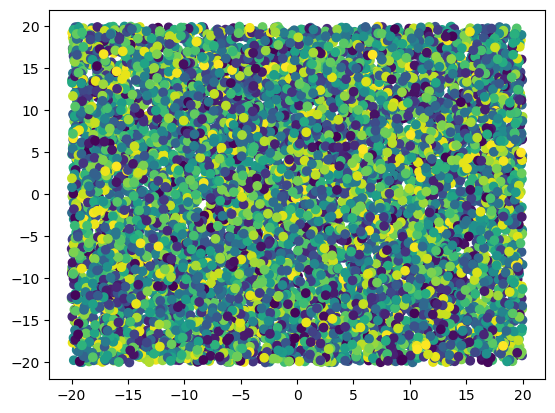

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2])

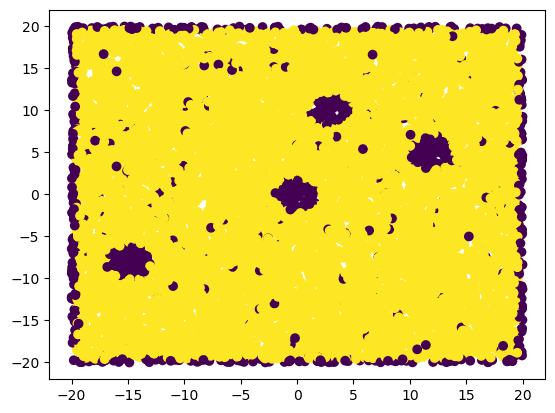

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=[is_safe(s) for s in X])

### Model

In [17]:
model = nn.Sequential(
    nn.Linear(dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Flatten(0, 1)
)

In [18]:
summary(model, (128, dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 64]             256
              ReLU-2              [-1, 128, 64]               0
            Linear-3              [-1, 128, 64]           4,160
              ReLU-4              [-1, 128, 64]               0
            Linear-5               [-1, 128, 1]              65
           Flatten-6                    [-1, 1]               0
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.02
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


### Loss

In [19]:
class CBFloss(nn.Module):
    def __init__(self, c1=1, c2=1, c3=1):
        super(CBFloss, self).__init__()
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.relu = nn.ReLU()
        
    def forward(self, x):
        global model
        pred = model(x)
        n_total = x.shape[0]
        n_safe, n_unsafe = 0, 0
        sum_safe, sum_unsafe, sum_derv = 0, 0, 0
        
        derv = torch_grad(model, x).sum(axis=1)
        for i in range(n_total):
            if is_safe(x[i]):
                sum_safe += self.relu(-pred[i])
                n_safe += 1
            else:
                sum_unsafe += self.relu(pred[i])
                n_unsafe += 1
            sum_derv += derv[i] @ calc_dyn(x[i])

        return self.c1 * sum_safe / n_safe \
                + self.c2 * sum_unsafe / n_unsafe \
                + self.c3 * sum_derv / n_total


In [20]:
loss_fn = CBFloss()

In [21]:
batch_size = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
for t in range(1):
    for b in range(N // batch_size):
        idxs = np.random.choice(np.arange(N), batch_size)
        loss = loss_fn(X[idxs])
        print(f"\t {t}: [{b}/{N // batch_size}] = {loss.item():.3f} ", end='\r')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


KeyboardInterrupt: 

In [62]:
pred = model(X[:100])

In [63]:
relu = nn.ReLU()

In [28]:
-pred[0]

tensor(0.3977, grad_fn=<NegBackward0>)

In [33]:
relu(-pred[0])

tensor(0.3977, grad_fn=<ReluBackward0>)